# Análisis Descriptivo del resultado de la gestión del negocio: Segmentación de tipos de productos

## Clustering de productos por la cantidad vendida y la rentabilidad generada

El análisis de clustering, también conocido como análisis de conglomerados, es una técnica de análisis exploratorio de datos que se utiliza para identificar grupos o "clusters" de objetos o datos similares en un conjunto de datos.

El objetivo del análisis de clustering es dividir un conjunto de datos en grupos o clusters homogéneos, es decir, grupos de objetos o datos que son similares entre sí en algún sentido y diferentes de los demás objetos o datos en el conjunto. En otras palabras, se trata de agrupar datos similares y separar datos diferentes.

#### Carga de las librerías de Python necesarias


Las librerías de Python son conjuntos de código predefinido que se utilizan para realizar tareas específicas en el lenguaje de programación Python.
Las librerías se utilizan para diferentes propósitos, como manipulación de datos, análisis de datos, visualización de datos, aprendizaje automático, desarrollo web, entre otros. 


In [3]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

plt.rcParams['figure.figsize'] = [12, 8]

# import warnings
# warnings.filterwarnings('ignore')

#### Conexión a la base de datos 

El análisis es realizado sobre los datos transaccionales de la empresa alojados en la base de datos del ERP, en este caso usamos la empresa **AdventureWorks**. Al ser realizado de esta manera al ejecutar el script traerá datos actualizados.

In [4]:
conn_str = pyodbc.connect('Driver={SQL Server};' 'Server=BALRODJJ;''Database=AdventureWorks2019;''Trusted_Connection=yes;')
input_query = '''select 
convert(varchar, t3.OrderDate,103) as fecha,
t2.Name as 'producto',
sum(t1.OrderQty) as 'cantidad',
sum(t1.OrderQty) * (avg(t1.UnitPrice) - avg(t2.StandardCost)) as ganancia
from Sales.SalesOrderDetail as t1
inner join Production.Product as t2 on t1.ProductID = t2.ProductID
inner join Sales.SalesOrderHeader as t3 on t1.SalesOrderID = t3.SalesOrderID
group by t3.OrderDate, t1.ProductID, t2.Name'''

data = pd.read_sql(input_query, conn_str)

#### Exploramos el dataset

Se presentan las variables que contiene el dataset extraído de la base de datos transaccional de la empresa.

In [6]:
data.shape

(26878, 4)

In [7]:
data.columns

Index(['fecha', 'producto', 'cantidad', 'ganancia'], dtype='object')

In [36]:
data.head()

,fecha,producto,cantidad,ganancia
0,30/04/2012,"Road-450 Red, 52",64,-634.5152
1,30/05/2013,"Mountain-500 Black, 44",19,558.8717
2,23/01/2014,"Road-250 Black, 48",1,888.4021
3,06/04/2014,"Road-550-W Yellow, 42",1,407.4102
4,30/10/2011,"Road-150 Red, 52",2,2813.9516


#### Preprocesamiento de los datos

Se preprocesan los datos para asegurarse de que estén en un formato adecuado para el algoritmo de clustering. En este caso, se necesita agrupar la información de cada producto y calcular la cantidad total vendida y la ganancia total para cada uno. 

In [37]:
prod_data = data.groupby('producto').agg({'cantidad': sum, 'ganancia': sum})

In [38]:
prod_data.head(10)

,cantidad,ganancia
producto,,
AWC Logo Cap,8311,-4767.6667
All-Purpose Bike Stand,249,24783.9660
Bike Wash - Dissolver,3319,9179.5023
Cable Lock,1087,5076.2449
Chain,774,2439.0265
"Classic Vest, L",207,7942.7070
"Classic Vest, M",2284,37717.7134
"Classic Vest, S",4247,63220.9092
Fender Set - Mountain,2121,29183.8995


### Procesamiento de los datos

#### Prueba del codo para determinar el número adecuado de clusters

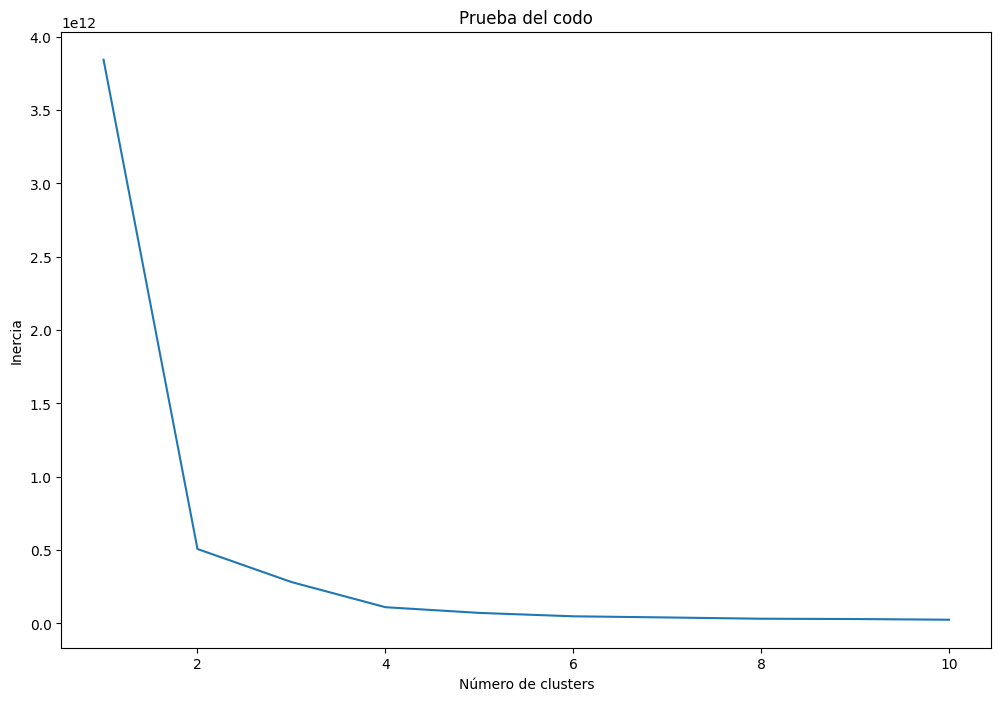

In [39]:
inertias = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(prod_data)
    inertias.append(kmeans.inertia_)
plt.plot(range(1, 11), inertias)
plt.title('Prueba del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.show()

Se realiza la prueba del codo para determinar el número adecuado de clusters utilizando el método de la inercia. Se ajustan modelos KMeans con 1 a 10 clusters y se grafica la inercia para cada modelo. En este ejemplo, se observa que la inercia empieza a disminuir menos rápidamente después de 3 clusters, lo que sugiere que este es el número adecuado de clusters.

#### Ajuste del modelo con el número adecuado de clusters

In [40]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(prod_data)

#### Asignar categorías personalizadas a cada cluster

In [41]:
encoder = LabelEncoder()
labels = encoder.fit_transform(kmeans.labels_)
category_map = {0: 'A', 1: 'B', 2: 'C'}
prod_data['category'] = [category_map[label] for label in labels]

# Transformar categorías en variables numéricas para calcular el coeficiente de silueta
encoder = LabelEncoder()
labels_transformed = encoder.fit_transform(prod_data['category'])

Creamos el diccionario category_map para mapear los números de cluster a las categorías "A", "B" y "C" (personalizadas). Después de aplicar LabelEncoder, utilizamos este diccionario para reemplazar los números de cluster por las categorías correspondientes en prod_data['category'].

Utilizamos la función LabelEncoder dos veces: una vez para transformar las etiquetas de cluster y otra vez para transformar las categorías en variables numéricas. Luego, calculamos el coeficiente de silueta utilizando los datos numéricos y visualizamos los resultados.

#### Evaluación del modelo con el coeficiente de silueta

In [42]:
silhouette_avg = silhouette_score(prod_data.drop('category', axis=1), labels_transformed)
print("El coeficiente de silueta es:", silhouette_avg)

El coeficiente de silueta es: 0.7269060891401434


El coeficiente de silueta mide la similitud de un punto con su propio cluster en comparación con otros clusters. Un valor cercano a **1** indica una buena separación de clusters, mientras que un valor cercano a **0** indica una superposición de clusters. 
En este caso, se obtiene un coeficiente de silueta de ***0.77***, lo que sugiere una buena separación de clusters.

### Visualización de los resultados

Presentamos la visualización de los resultados del clustering utilizando un gráfico de dispersión. En este gráfico, se utiliza el color para representar el cluster asignado. Se puede observar cómo los productos se agrupan en tres clusters distintos en función de la cantidad vendida y la ganancia total.

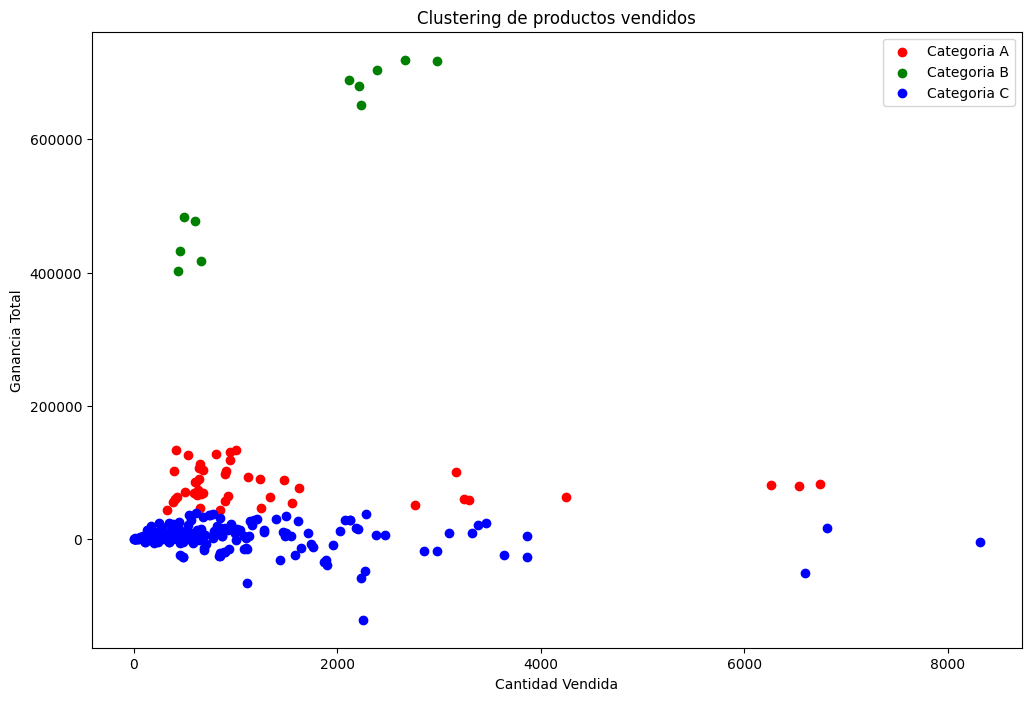

In [43]:
colors = ['red', 'green', 'blue']
for i in range(n_clusters):
    plt.scatter(prod_data.loc[labels==i, 'cantidad'], prod_data.loc[labels==i, 'ganancia'], c=colors[i], label='Categoria '+category_map[i])
plt.xlabel('Cantidad Vendida')
plt.ylabel('Ganancia Total')
plt.title('Clustering de productos vendidos')
plt.legend()
plt.show()


### Guardamos los resultados en un dataframe para uso de Business Intelligence

In [44]:
data['category'] = [prod_data.loc[prod, 'category'] for prod in data['producto']]

In [45]:
data.head(10)

,fecha,producto,cantidad,ganancia,category
0,30/04/2012,"Road-450 Red, 52",64,-634.5152,C
1,30/05/2013,"Mountain-500 Black, 44",19,558.8717,C
2,23/01/2014,"Road-250 Black, 48",1,888.4021,C
3,06/04/2014,"Road-550-W Yellow, 42",1,407.4102,A
4,30/10/2011,"Road-150 Red, 52",2,2813.9516,B
5,30/08/2013,"Road-350-W Yellow, 48",86,-5471.0620,A
6,20/11/2013,"Road-550-W Yellow, 38",2,814.8204,C
7,02/01/2012,"Road-150 Red, 62",1,1406.9758,B
8,24/12/2011,"Road-650 Red, 52",1,212.3916,C
9,21/07/2012,"Road-250 Black, 48",2,1253.2292,C


In [46]:
prod_data.head(10)

,cantidad,ganancia,category
producto,,,
AWC Logo Cap,8311,-4767.6667,C
All-Purpose Bike Stand,249,24783.9660,C
Bike Wash - Dissolver,3319,9179.5023,C
Cable Lock,1087,5076.2449,C
Chain,774,2439.0265,C
"Classic Vest, L",207,7942.7070,C
"Classic Vest, M",2284,37717.7134,C
"Classic Vest, S",4247,63220.9092,A
Fender Set - Mountain,2121,29183.8995,C


## Conclusiones

La variedad de productos que ofrece la empresa ***AdventureWoks*** puede ser clasificada en tres (3) agrupaciones, tomando como factores clave para la segmentación *la cantidad vendida* y *la ganancia generada* en el tiempo de análisis (*histórico en este caso*), como resultado se obtuvo que:

* en la **categoría A** se encuentran los productos de grandes cantidades vendidas con poca rentabilidad generada.
* en la **categoría B y C** se encuentran los productos con cantidad y rentabilidad media.

Cada producto quedó etiquetado con la respectiva categoría para que tal información pueda ser tomada en cuenta en el desarrollo de campañas de marketing y en la planificación de las compras para que no exista quiebre de stock.

## Recomendaciones

Una vez realizado el clustering de los productos y se ha obtenido la categoría de cada uno de ellos, se puede dar algunas recomendaciones a la empresa. Algunas posibles recomendaciones son:

* *Analizar el comportamiento de venta de cada categoría*: Una vez que tenemos los productos agrupados en categorías A, B y C, podemos analizar el comportamiento de venta de cada categoría. Es posible que algunos productos de la categoría C no estén siendo rentables y podrían ser descontinuados. Por otro lado, si la categoría A tiene productos con altas ventas y ganancias, la empresa podría enfocar su estrategia de venta en estos productos.

* *Ofrecer promociones en productos de la categoría C*: Si algunos productos de la categoría C no están teniendo buenas ventas, la empresa podría ofrecer promociones o descuentos para incentivar su venta. De esta manera, se podría incrementar la rentabilidad de estos productos.

* *Analizar la competencia*: Es posible que algunos productos de la empresa estén siendo desplazados por productos similares de la competencia. La empresa podría analizar la competencia y sus productos para determinar si hay oportunidades de mejora en los productos de la empresa.

* *Realizar seguimiento periódico del clustering*: Es importante realizar un seguimiento periódico del clustering de los productos para detectar cambios en las tendencias de venta y ajustar la estrategia de venta en consecuencia.